In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Шаг. Загрузка данных

In [2]:
usersdf = pd.read_csv('/datasets/users_go.csv')

In [3]:
usersdf.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
ridesdf = pd.read_csv('/datasets/rides_go.csv')

In [5]:
ridesdf.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
subdf = pd.read_csv('/datasets/subscriptions_go.csv')

In [7]:
subdf.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Шаг 2. Предобработка данных

In [8]:
ridesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В столбце date у нас тип данных object. Поменяем на **datetime**.

In [9]:
ridesdf['date'] = pd.to_datetime(ridesdf['date'], format="%Y-%m-%d")

In [10]:
ridesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Нужно добавить отдельный **столбец с месяцами**.

In [11]:
ridesdf['month'] = ridesdf['date'].dt.month

In [12]:
ridesdf.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Отлично. Теперь займёмся **дубликатами**. Проверим сначала на явные.

In [13]:
usersdf.duplicated().sum()

31

In [14]:
usersdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [15]:
usersdf[usersdf.duplicated() == True]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [16]:
usersdf[usersdf['user_id'] == 16]

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra


По какой-то причине в базу в последнее время стали повторно заноситься уже существующие пользователи, несмотря на уникальный user_id. Надо сообщить об этом. А пока просто удалим все эти дубли.

In [17]:
usersdf = usersdf.drop_duplicates()

In [18]:
usersdf[usersdf.duplicated() == True]

,user_id,name,age,city,subscription_type


In [19]:
ridesdf[ridesdf.duplicated() == True]

,user_id,distance,duration,date,month


С явными разобрались. Теперь проверим названия городов. Вдруг там есть разные варианты написания.

In [20]:
usersdf['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

Нет, всё в порядке. По остальным данным искать неявные дубликаты смысла не вижу.

Проверим **пропуски**.

In [21]:
usersdf.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [22]:
ridesdf.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Ни одного пропуска. Можем заняться исследованием данных.

#### Шаг 3. Исследовательский анализ данных

Тут нам нужно описать и визуализировать общую информацию о пользователях и поездках по конкретным показателям. Они будут в подпунктах.

##### Частота встречаемости городов

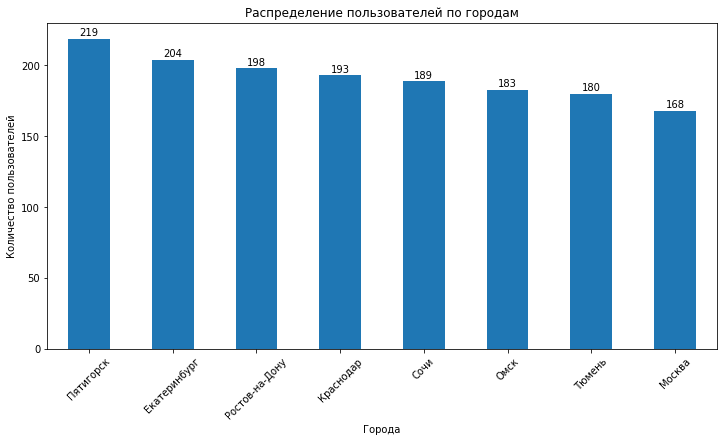

In [23]:
city_counts = usersdf['city'].value_counts()

# Создаем график
ax = city_counts.plot.bar(
    rot=45,
    xlabel='Города',
    ylabel='Количество пользователей',
    title='Распределение пользователей по городам',
    figsize=(12, 6)
)

# Добавляем числовые значения над столбцами
for i, count in enumerate(city_counts):
    ax.text(i, count + 0.5, str(count), 
            ha='center', va='bottom', fontsize=10)

Распределение по городам примерно равномерное. Москва встречается реже всего. Уверен, эта картина не является характерной. Наверняка данные собрали так, что было проще проверить какие-то гипотезы.

##### Соотношение пользователей с подпиской и без подписки

In [24]:
usersdf['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

835 обычных пользователей, 699 с подпиской.

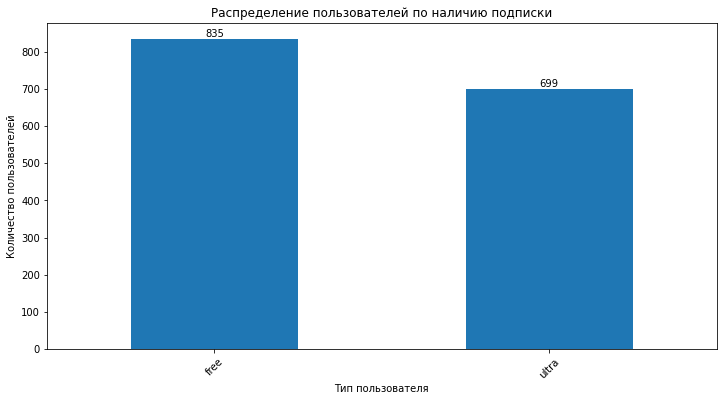

In [25]:
sub_counts = usersdf['subscription_type'].value_counts()

ax = sub_counts.plot.bar(
    rot=45,
    xlabel='Тип пользователя',
    ylabel='Количество пользователей',
    title='Распределение пользователей по наличию подписки',
    figsize=(12, 6)
)

# Добавляем числовые значения над столбцами
for i, count in enumerate(sub_counts):
    ax.text(i, count + 0.5, str(count), 
            ha='center', va='bottom', fontsize=10)

Пользователей примерно поровну, без подписки немного больше.

##### Возраст пользователей

In [26]:
usersdf['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Среднее значение 24.9. Минимум 12 (возможно тогда это был нижний порог?), максимум 43. 

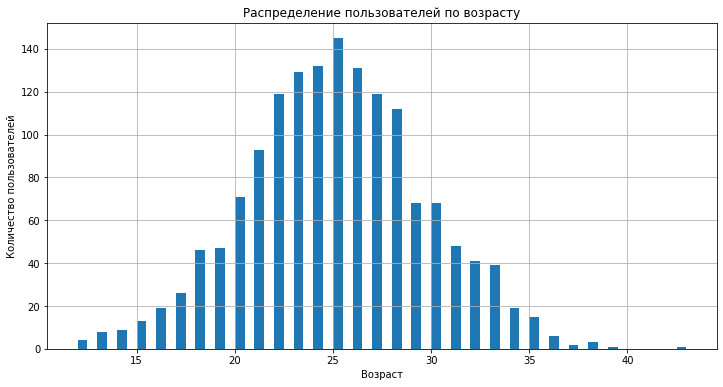

In [27]:
usersdf['age'].plot(kind='hist', bins=62, figsize=(12, 6))
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по возрасту')
plt.grid()
plt.show()

Распределение близко к нормальному.

<AxesSubplot:>

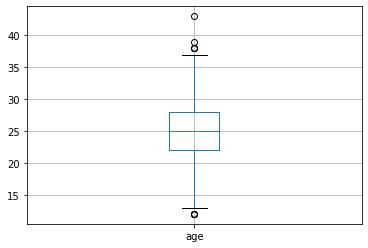

In [28]:
usersdf.boxplot(column='age')

Можно сделать вывод, что почти все наши пользователи в границах 13-37 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

In [29]:
ridesdf['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Это расстояние поездок в метрах. Среднее 3070 метров. Минимум меньше 1, максимум 7211. 

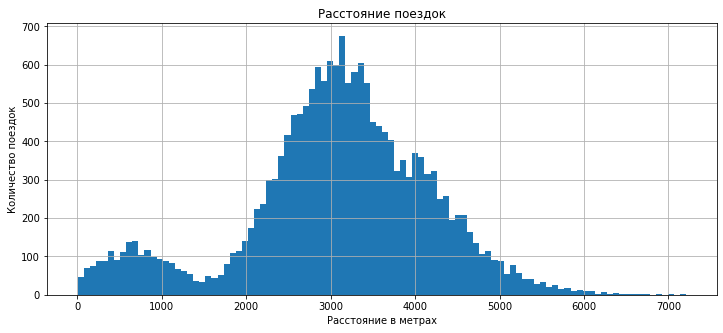

In [30]:
ridesdf['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок')
plt.grid()
plt.show()

Распределение похоже на бимодальное, мы видим 2 явных колокола. Вероятно, это 2 разных типа поездок. У меня есть идея, что левый купол от 0 до 1500 метров демонстрирует поездки до ближайшего метро и других остановок общественного транспорта (и наоборот от них к дому/работе/учёбе). А основная масса - это в основном поездки до конечного пункта назначения. Также у нас правый склон графика выглядит немного рваным, возможно это тоже какая-то тенденция.

Запомним, что нас интересуют пики в районе 1.5, 3 и 4 км и посмотрим на эти графики в разрезе сезонов и городов в конце проекта.

##### Продолжительность поездок

In [31]:
ridesdf['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Время посчитано в минутах. Минимум 0.5 минут, максимум почти 40.8. Среднее 17.8.

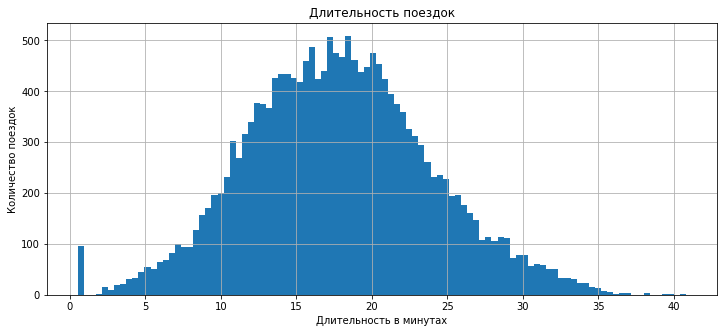

In [32]:
ridesdf['duration'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество поездок')
plt.title('Длительность поездок')
plt.grid()
plt.show()

Распределение похоже на нормальное с выбросом около 1. Почти 100 значений в районе 0-1 метров. Здесь явно есть проблема, нужно будет постараться понять, с чем она связана. Возможно это из-за потери данных, или это случаи когда при старте возникает ошибка (например самокает не едет).

Интересно, что тут мы не видим необычной картины двух пиков, которую наблюдали на графике расстояния.

#### Шаг 4. Объединение данных

##### Продолжительность поездок

Объединим данные о пользователях, поездках и подписках в один датафрейм методом merge().

In [33]:
usersdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [34]:
ridesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [35]:
data = pd.merge(usersdf, ridesdf, on='user_id', how='left')

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


In [37]:
subdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [38]:
data = pd.merge(data, subdf, on='subscription_type', how='left')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Отлично, всё на месте. 

##### Теперь из этого датафрейма нужно создать ещё два:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

In [40]:
users_free = data[data['subscription_type'] == 'free']
users_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [41]:
users_sub = data[data['subscription_type'] == 'ultra']
users_sub.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

In [42]:
users_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

Пользователи без подписки совершили 11568 поездок. Средняя дальность 3045 метров. Минимум 1 метр, максимум 7211.

In [43]:
users_sub['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Подписчики совершили 6500 поездок, что почти в 2 раза меньше. Средняя дальность 3115 метров. Минимум 244, максимум 5700.

Стандартное отклонение заметно ниже у тех, кто пользуется подпиской. Среднее и медиана примерно одинаковы, а квартили, соответственно, у подписавшихся расположены ближе к центру.

То что у пользователей с подпиской не было поездок короче 244 метра противоречит гипотезе о том, что поездки длинной до 10 метров связаны с поломками в самокате, тк в таком случае обе группы бы сталкивались с такой проблемой.

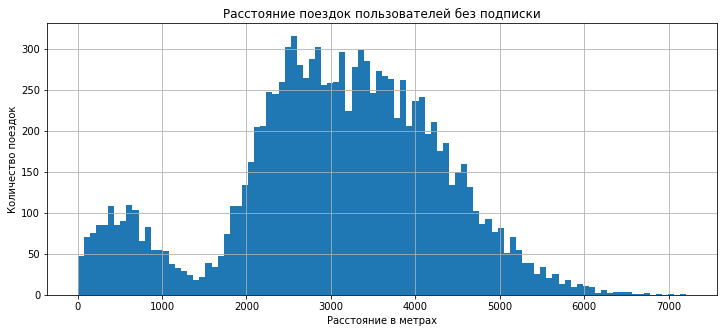

In [44]:
users_free['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей без подписки')
plt.grid()
plt.show()

Тут опять видны 2 пика бимодального распределения. Надо проверить, есть ли такая же картина у подпичиков.

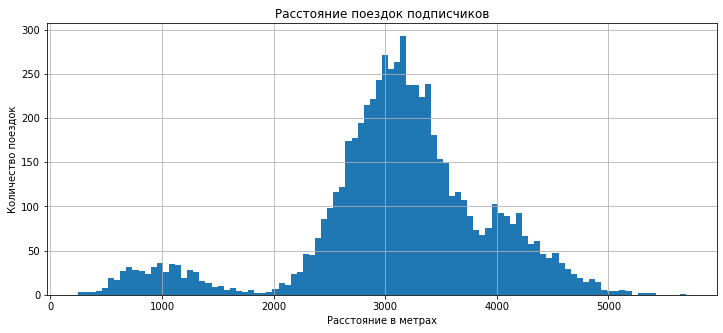

In [45]:
users_sub['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок подписчиков')
plt.grid()
plt.show()

Снова 2 пика, которые мы видели раньше. Только на прошлом графике левый пик был на значении 500 метров, а здесь на 1000. Мода совпадает. Также на этом графике мы видим то ли ещё один пик на значении 4000 метров, то ли просто странный разброс, который даёт такую "рваную" картину на правой стороне.

Теперь посмотрим на длительность поездок.

In [46]:
users_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

В среднем 17.4 минуты. Минимум 0.5 ровно, что выглядит необычно, учитывая точность в шесть знаков после запятой. Максимум 34.9.

In [47]:
users_sub['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Среднее равно 18.5 минут. Минимум 3.8 минут, максимум 21.9. Стандартной отклонение чуть меньше, но как и в первой группе близко к 6.

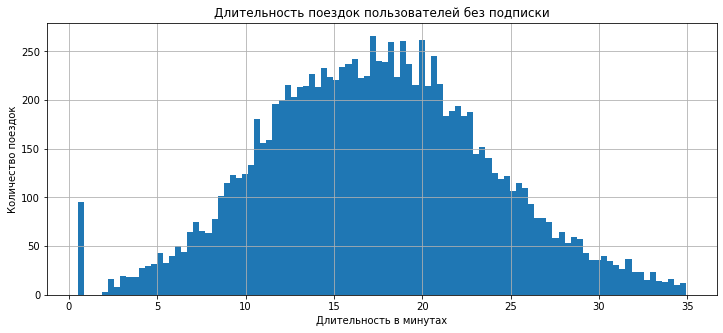

In [48]:
users_free['duration'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество поездок')
plt.title('Длительность поездок пользователей без подписки')
plt.grid()
plt.show()

Снова близкое к нормальному распределение с выбросом из 100 значений около нуля. Дополнительно необычно, что судя по количеству значений в зоне выброса, такой аномалии не будет во второй группе, и они все пришлись на пользователей без подписки. Посмотрим на второй график.

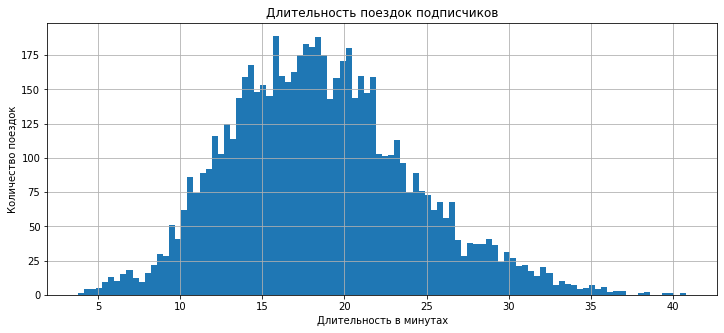

In [49]:
users_sub['duration'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество поездок')
plt.title('Длительность поездок подписчиков')
plt.grid()
plt.show()

Да, мы были правы, аномалия в почти 100 необычно коротких поездок есть только у пользователей без подписки. Это странно. Вряд ли здесь проблема с новыми людьми, которые не могут разобраться в работе приложения/самоката. Тогда может сбоит система и данные теряются на каком-то этапе?

В остальном, тут различий между группами меньше. Мы видим, что значения во второй группе снова расположены чуть плотнее. Мода совпадает. Во второй группе есть несколько редких значений от 35 до 41, что выглядит правдоподобно, в отличие от первой группы, где на отметке в 35 минут график резко обрывается.

Давайте проверим аномально короткие по времени поездки.

In [50]:
users_free[users_free['duration'] < 2]

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6531,701,Иван,31,Екатеринбург,free,4196.445201,0.5,2021-08-31,8,8,50,0
6570,704,Мирон,29,Ростов-на-Дону,free,4830.824371,0.5,2021-10-14,10,8,50,0
6680,712,Дарья,28,Москва,free,4684.004397,0.5,2021-03-04,3,8,50,0
6695,713,Святослав,30,Краснодар,free,5215.642710,0.5,2021-02-25,2,8,50,0
6768,718,Владислава,31,Москва,free,5197.436649,0.5,2021-02-11,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17004,1460,Жанна,27,Пятигорск,free,5531.335845,0.5,2021-01-19,1,8,50,0
17242,1477,Ян,17,Сочи,free,6724.932981,0.5,2021-01-12,1,8,50,0
17314,1483,Роберт,26,Екатеринбург,free,4445.481070,0.5,2021-03-06,3,8,50,0
17505,1496,Яна,19,Москва,free,5722.551787,0.5,2021-02-14,2,8,50,0


In [51]:
broken = users_free[users_free['duration'] < 2]
broken['duration'].unique()

array([0.5])

In [52]:
broken['distance'].describe()

count      95.000000
mean     5113.176549
std       658.254104
min      4030.308008
25%      4611.510820
50%      5052.769411
75%      5488.459099
max      7211.007745
Name: distance, dtype: float64

In [53]:
broken['user_id'].value_counts()

1364    2
1007    2
1243    2
973     2
1224    2
       ..
1317    1
804     1
931     1
1057    1
1176    1
Name: user_id, Length: 90, dtype: int64

Мы видим 95 поездок. У всех длительность ровно 0.5 минут, при этом расстояние от 4 до 7+ км. Почти все пользователи в списке являются уникальными (5 пользователей с двумя поездками). Все остальные столбцы, на первый взгляд, достаточно вариативны.

Возможно это баг или возможно такое значение присваивается специально всем поездкам, информация о длительности которых теряется.

Т.к. все остальные столбцы по этим поездкам выглядят нормально, мы не будем ничего менять и удалять, а просто не возьмём эти данные по длительности, когда будем проверять гипотезы.

<AxesSubplot:>

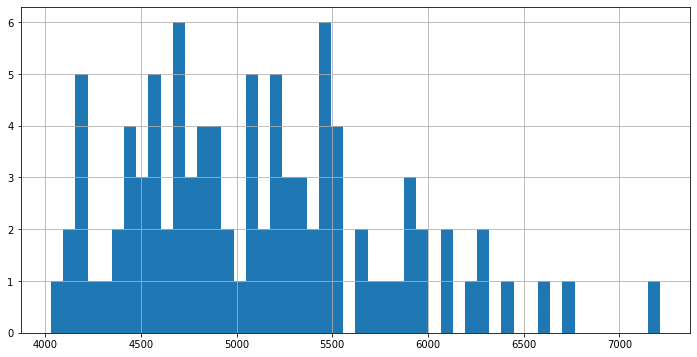

In [54]:
broken['distance'].hist(bins = 50, figsize=(12,6))

Давайте ещё проведём дополнительное сравнение расстояния и времени поездок по типам пользователей, но теперь сравнивая средние показатели каждого пользователя.

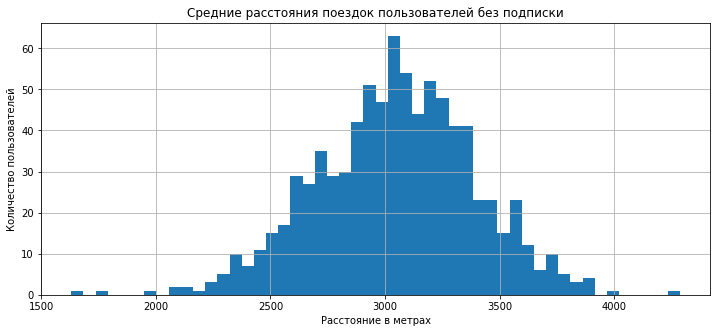

In [55]:
users_free.groupby('user_id')['distance'].mean().plot(kind='hist', bins=50, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.title('Средние расстояния поездок пользователей без подписки')
plt.grid()
plt.show()

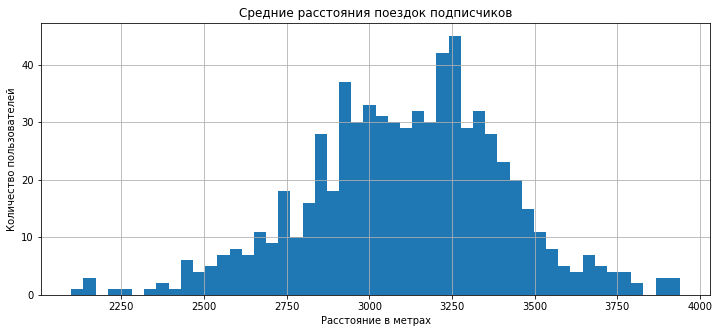

In [56]:
users_sub.groupby('user_id')['distance'].mean().plot(kind='hist', bins=50, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество пользователей')
plt.title('Средние расстояния поездок подписчиков')
plt.grid()
plt.show()

По расстоянию различий стало ещё меньше. Распределение средних у подписчиков немного неаккуратное, но достаточно похоже на нормальное. Середина в обоих случаях в районе 3.1-3.2 км.

Теперь обработаем аномалии и посмотрим на длительность.

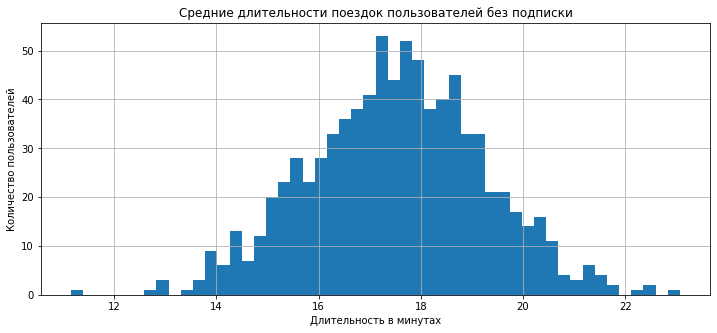

In [57]:
users_free[users_free['duration'] > 2].groupby('user_id')['duration'].mean().plot(kind='hist', bins=50, figsize=(12,5))
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество пользователей')
plt.title('Средние длительности поездок пользователей без подписки')
plt.grid()
plt.show()

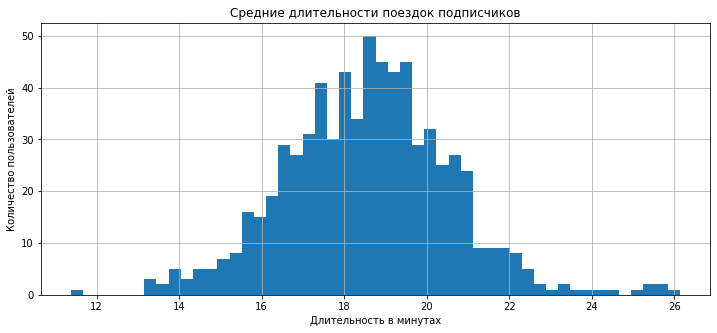

In [58]:
users_sub.groupby('user_id')['duration'].mean().plot(kind='hist', bins=50, figsize=(12,5))
plt.xlabel('Длительность в минутах')
plt.ylabel('Количество пользователей')
plt.title('Средние длительности поездок подписчиков')
plt.grid()
plt.show()

Очень схожие картины, распределения близкие к нормальным. Похоже, что подписчики в среднем ездят немного дольше. У них пик в районе 19, тогда как у первой группы между 17 и 18.

#### Шаг 5. Подсчёт выручки

##### Создадим датафрейм с агрегированными данными о поездках для каждого пользователя за каждый месяц на основе датафрейма с объединёнными данными из шага 4: 
- найдем суммарное расстояние
- количество поездок
- суммарное время

На данном этапе, как и при проверки гипотез данный датафрейм будет нужен нам для анализа выручки. Поскольку аномальные значения в столбце длительности будут влиять на общую картину, мы не возьмём строки с ними.

In [59]:
agg_data = (
    data[data['duration'] > 2].groupby(['user_id', 'month'])
    .agg(
        total_distance = ('distance', 'sum'),
        total_rides = ('distance', 'count'),
        total_duration = ('duration', 'sum')
    ).reset_index()
)

In [60]:
agg_data.head()

,user_id,month,total_distance,total_rides,total_duration
0,1,1,7027.511294,2,41.416640
1,1,4,754.159807,1,6.232113
2,1,8,6723.470560,2,44.776802
3,1,10,5809.911100,2,31.578017
4,1,11,7003.499363,3,53.397424


In [61]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


##### В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь

Приведённый ниже способ кажется мне не самым оптимальным, но он должен быть простым и надёжным.

Создаём новый датафрейм.

In [63]:
not_data = data.copy()

Округляем время поездки до большего целого значения.

In [64]:
not_data['duration'] = np.ceil(not_data['duration'])

Агрегируем данные как на прошлом шаге, но теперь не добавляем общее расстрояние, зато добавляем тип подписки.

In [65]:
not_data = (
    not_data[not_data['duration'] > 2].groupby(['user_id', 'month','subscription_type'])
    .agg(
        total_rides = ('distance', 'count'),
        total_duration = ('duration', 'sum')
    ).reset_index()
)

Получилось так.

In [66]:
not_data.head()

,user_id,month,subscription_type,total_rides,total_duration
0,1,1,ultra,2,42.0
1,1,4,ultra,1,7.0
2,1,8,ultra,2,46.0
3,1,10,ultra,2,32.0
4,1,11,ultra,3,56.0


In [67]:
not_data['total_duration'] = not_data['total_duration'].astype(int)

Теперь добавляем новый столбец.

In [68]:
not_data['total_price'] = not_data['subscription_type']

Создадим функцию для подсчёта.

In [69]:
def calculate_price(row):
    if row['total_price'] == 'ultra':
        return row['total_duration']*6 + 199
    else:
        return row['total_duration']*8 + row['total_rides']*50

Теперь применим её, чтобы создать столбец с данными.

In [70]:
not_data['total_price'] = not_data.apply(calculate_price, axis=1)

In [71]:
not_data.head()

,user_id,month,subscription_type,total_rides,total_duration,total_price
0,1,1,ultra,2,42,451
1,1,4,ultra,1,7,241
2,1,8,ultra,2,46,475
3,1,10,ultra,2,32,391
4,1,11,ultra,3,56,535


Добавим новый столбец в agg_data.

In [72]:
agg_data['total_price'] = not_data['total_price']

In [73]:
agg_data.head()

,user_id,month,total_distance,total_rides,total_duration,total_price
0,1,1,7027.511294,2,41.416640,451
1,1,4,754.159807,1,6.232113,241
2,1,8,6723.470560,2,44.776802,475
3,1,10,5809.911100,2,31.578017,391
4,1,11,7003.499363,3,53.397424,535


#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Т.к. мы будем проверять 3 гипотезы я считаю правильным использовать поправку Бонферрони. Таким образом возьмём базовый p-value <= 0.05 и разделим его на 3. Округляем в меньшую сторону и получаем 0.016. Всё, что меньше этого значения, будем считать значимым.

У нас есть две независимые выборки. Нужно узнать, различается ли дисперсия в них, чтобы понимать, какой критерий использовать - Стьюдента или Уэлча. Уточню, что т.к. во всех тестах у нас достаточно большие выборки, проверять их распределение не требуется блягодаря цпт.

In [74]:
statistic, p_value = stats.levene(users_sub['duration'], users_free[users_free['duration'] > 2]['duration'])
print(p_value)

3.2376319108520455e-24


Дисперсии значимо различаются. Выбираем Уэлча. 

Сформулируем нулевую и альтернативную гипотезы.

Нулевая: без подписки ездят столько же или больше.

Альтернативная: подписчики ездят дольше.

Укажем alternative='greater', чтобы проверить именно предположение о том, что пользователи с подпиской тратят больше времени на поездки.

In [75]:
statistic, p_value = stats.ttest_ind(users_sub['duration'], users_free[users_free['duration'] > 2]['duration'], equal_var=False, alternative='greater')
print(p_value)

1.6162210195311063e-29


P-value очень низок, нам следует принять **альтернативную** гипотезу, что **подписавшиеся тратят больше времени** на поездки.

In [76]:
users_sub['duration'].mean()

18.54198516280583

In [77]:
users_free[users_free['duration'] > 2]['duration'].mean()

17.530771268800226

Разница примерно в 1 минуту или в 5,5%.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Мне такая формулировка и метод проверки кажутся странными. Логичнее было бы получить более полную информацию. Только более дальние поедзки ускоряют износ? Или короткие тоже, но не так сильно? Может быть есть рекомендованный интервал, например от 2700 до 3200 метров? Тогда мы могли бы оценить, какой процент поездок в него попадает и т.п. 

Тут для проверки мы используем одновыборочный т-тест. Опять же выберем одностороннюю гипотезу в качестве альтернативной.

Нулевая: среднее расстояние поездки меньше или равно 3130 метров.

Альтернативная: среднее расстояние больше 3130 метров.

In [78]:
statistics, p_value = stats.ttest_1samp(users_sub['distance'], 3130, alternative='greater')
print(p_value)

0.9195368847849785


P-value близок к 1, это значит, что нам нужно принять **нулевую** гипотезу. У подписчиков среднее **расстояние не больше 3130 метров**.

In [79]:
users_sub['distance'].mean()

3115.4453880370247

In [80]:
users_free['distance'].mean()

3045.495281671816

У пользователей без подписки среднее расстояние ещё ниже.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Для меня данная формулировка звучит двояко. Я склоняюсь к тому, что нужно сравнить суммарную выручку каждой из групп, исходя из формулировки. Но, возможно, имелось в виду, что нужно сравнить средние показатели пользователей групп. В реальной жизни я бы уточнил задачу. В данной ситуации проверю оба варианта. Поскольку количество проверок увеличилось, давайте перерасчитаем поправку Бонферрони для этого этапа и сделаем пороговым значение p=0.0125.

###### Сравним суммарные значения

Нулевая гипотеза: суммарная помесячная выручка от подписчиков меньше или равна выручке от пользователей без подписки.

Альтернативная гипотеза: суммарная помесячная выручка от подписчиков больше, чем выручка от пользователей без подписки.

Соберём данные для сравнения.

In [119]:
sub_total = not_data.loc[not_data['subscription_type'] == 'ultra'].groupby('month').sum()

In [120]:
free_total = not_data.loc[not_data['subscription_type'] == 'free'].groupby('month').sum()

In [125]:
sub_total.head()

,user_id,total_rides,total_duration,total_price
month,,,,
1,140107,584,11083,144108
2,117220,468,9021,124572
3,139850,561,10634,142608
4,126521,551,10482,137318
5,142898,597,11440,149235


Проверим дисперсии.

In [121]:
statistic, p_value = stats.levene(sub_total['total_price'], free_total['total_price'])
print(p_value)

0.5931253439634436


Такой p-value значит, что различие дисперсий стоит считать незначительным.

In [84]:
statistic, p_value = stats.ttest_ind(sub_total['total_price'], free_total['total_price'], alternative='greater')
print(p_value)

0.9999999999997109


P-value практически равен 1. Принимаем **нулевую гипотезу** и делаем вывод, что помесячная **выручка от пользователей с подпиской не выше**, чем выручка от пользователей без подписки.

На всякий случай уточню, что это не говорит ничего о том, какой тип пользователей для нас выгоднее, т.к. это суммарная выручка, а подписавшихся в нашей статистике было существенно меньше.

In [112]:
sub_total['total_price'].sum()

1644537

In [86]:
free_total['total_price'].sum()

2228594

###### Сравним средние значения

Нулевая гипотеза: средняя помесячная выручка от подписчиков меньше или равна выручке от пользователей без подписки.

Альтернативная гипотеза: средняя помесячная выручка от подписчиков больше, чем выручка от пользователей без подписки.

In [87]:
sub_avg = not_data.loc[not_data['subscription_type'] == 'ultra'].groupby('month').mean()

In [88]:
free_avg = not_data.loc[not_data['subscription_type'] == 'free'].groupby('month').mean()

Проверим дисперсии.

In [89]:
statistic, p_value = stats.levene(sub_avg['total_price'], free_avg['total_price'])
print(p_value)

0.5780363463239496


Такой p-value значит, что различие дисперсий стоит считать незначительным.

In [90]:
statistic, p_value = stats.ttest_ind(sub_avg['total_price'], free_avg['total_price'], alternative='greater')
print(p_value)

8.348737816273289e-13


P-value близок к 0 и меньше порогового значения. Это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной, то есть **в среднем подписчик приносит нам больше выручки**, чем пользователь без подписки.

In [91]:
sub_avg['total_price'].sum()

4352.0357341960525

In [92]:
free_avg['total_price'].sum()

3951.491714857441

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нам понадобился бы парный т-тест. 

Дополнительно уточню, что для данного теста было бы правильным собрать больше информации или изменить его дизайн. На количество обращений могут повлиять самые разные факторы. Например, если мы берём данные за месяц до обновления и первый месяц после обновления, то нам стоит учесть количество осадков, температурные изменения, новые законы, связаддые с пдд, начало и конец учебного года (помним, что наша аудитория в том числе студенты и школьники). Всё это для предложенного теста стоило бы учесть, т.к. при падении и росте спроса у нас будет пропорционально меняться количество обращений. А обновление парка самокатов и акции могут влиять на лояльность пользователей и их мотивацию писать в поддержку.

**Приложение**

**Вернёмся к анализу "двух колоколов". Посмотрим сначала по сезонам.**

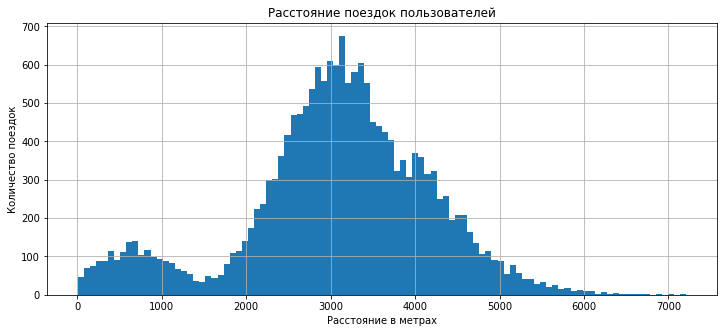

In [93]:
data['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей')
plt.grid()
plt.show()

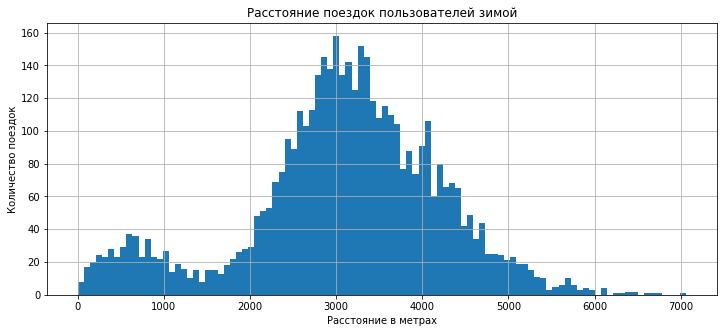

In [94]:
winter = data[data['month'].isin([12,1,2])]
winter['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей зимой')
plt.grid()
plt.show()

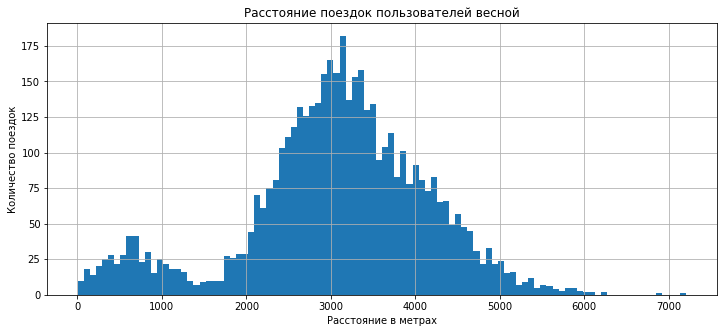

In [95]:
spring = data[data['month'].isin([3,4,5])]
spring['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей весной')
plt.grid()
plt.show()

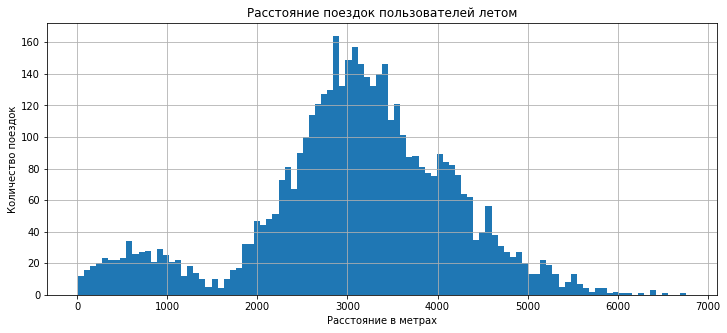

In [96]:
summer = data[data['month'].isin([6,7,8])]
summer['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей летом')
plt.grid()
plt.show()

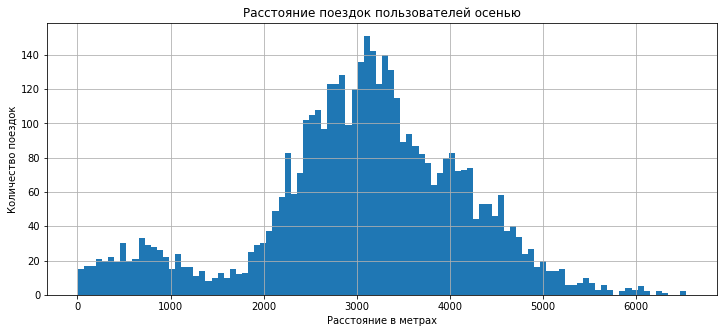

In [97]:
autumn = data[data['month'].isin([9,10,11])]
autumn['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей осенью')
plt.grid()
plt.show()

**Картина почти идентичная, ничего необычного. Проверим города.**

In [98]:
data['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

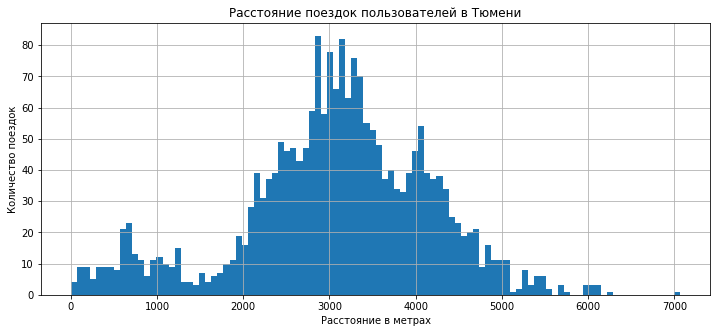

In [99]:
tyumen = data[data['city'] == 'Тюмень']
tyumen['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Тюмени')
plt.grid()
plt.show()

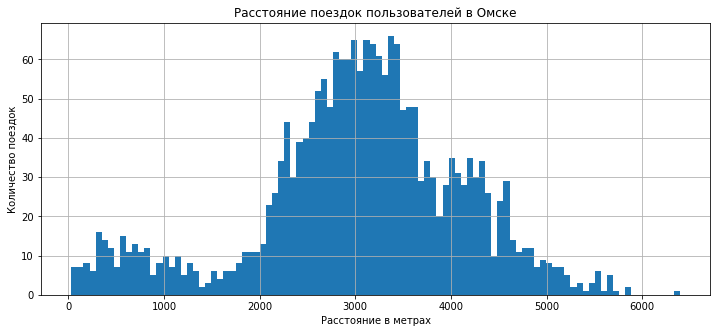

In [100]:
omsk = data[data['city'] == 'Омск']
omsk['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Омске')
plt.grid()
plt.show()

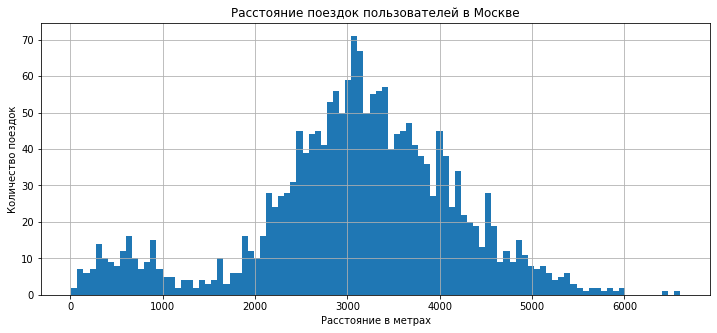

In [101]:
moskow = data[data['city'] == 'Москва']
moskow['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Москве')
plt.grid()
plt.show()

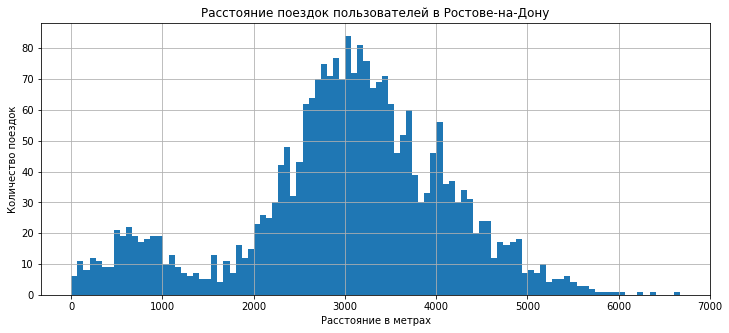

In [102]:
rostov = data[data['city'] == 'Ростов-на-Дону']
rostov['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Ростове-на-Дону')
plt.grid()
plt.show()

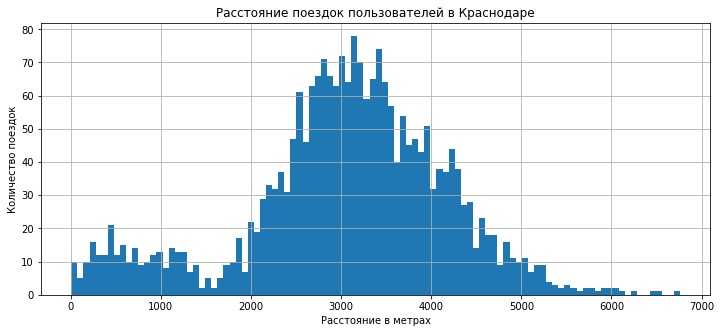

In [103]:
krasnodar = data[data['city'] == 'Краснодар']
krasnodar['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Краснодаре')
plt.grid()
plt.show()

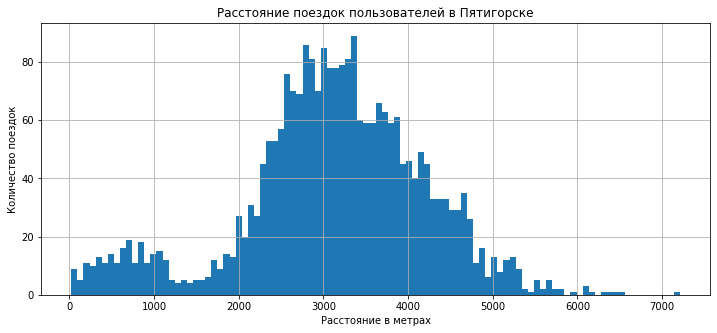

In [104]:
pyatigorsk = data[data['city'] == 'Пятигорск']
pyatigorsk['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Пятигорске')
plt.grid()
plt.show()

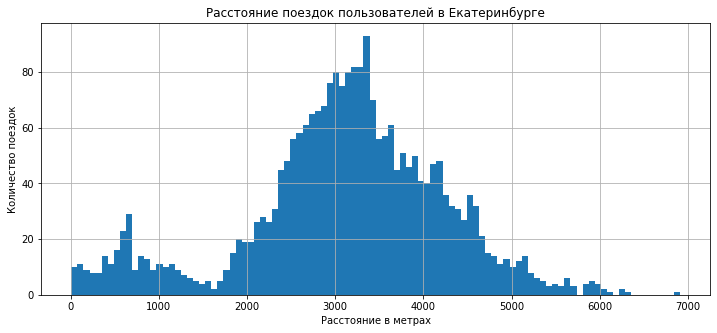

In [105]:
ekaterinburg = data[data['city'] == 'Екатеринбург']
ekaterinburg['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Екатеринбурге')
plt.grid()
plt.show()

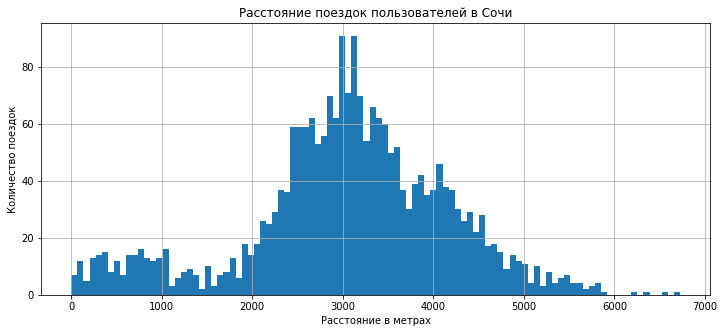

In [106]:
sochi = data[data['city'] == 'Сочи']
sochi['distance'].plot(kind='hist', bins=100, figsize=(12,5))
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.title('Расстояние поездок пользователей в Сочи')
plt.grid()
plt.show()

In [107]:
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [108]:
correlation = data[['distance', 'age']].corr()
print(correlation)

          distance       age
distance  1.000000 -0.000226
age      -0.000226  1.000000


Что ж, раз мы везде видим эти пики, наверное, это нормальная картина для кикшеринга.

Остановлюсь на гипотезе, что это про два типа поездок, до ближайшего нужного общественного транспорта и до конечного пункта назначения.